In [ ]:
from pyspark.sql import SparkSession
from IPython.display import display

# Apache Spark

In [ ]:
spark = SparkSession.builder.appName("intro_spark").getOrCreate()
        
# check if Adaptive Query Execution (AQE) is enabled
print(spark.conf.get("spark.sql.adaptive.enabled"))

df = spark.read.parquet("yellow_tripdata_2023-05.parquet")
print(df.rdd.getNumPartitions())

In [6]:
print(f"{spark.sparkContext.defaultParallelism} cores available")

24 cores available


## Spark Basics

Note that the [Spark Docs](https://spark.apache.org/docs/latest/index.html) are probably the best source of information about Spark

### I/O 

#### Reading Data

Object: `pyspark.sql.DataFrameReader`

Entry point: spark.read (batch) or spark.readStream (streaming).

Formats: csv, json, parquet, orc, avro, jdbc, delta, etc.

Common options:

"header"="true|false" (CSV/JSON)

"inferSchema"="true|false"

"delimiter"="," (CSV)

"path"="..."

#### Writing Data

Object: `pyspark.sql.DataFrameWriter`

Entry point: df.write (batch) or df.writeStream (streaming).

Need format, mode, and options.

Save options:


1. append: Append contents of this DataFrame to existing data.

1. overwrite: Overwrite existing data.

1. error or errorifexists: Throw an exception if data already exists.

1. ignore: Silently ignore this operation if data already exists.


### User Defined Functions (UDFs)

In Spark, it is generally best to use built-in functions before resorting to UDFs. Built-in functions are implemented in the Spark engine itself, benefit from the Catalyst optimizer (e.g., predicate pushdown, whole-stage code generation, vectorized execution), and therefore execute efficiently at scale. UDFs, on the other hand, are opaque to the Catalyst optimizer and often force row-by-row execution, which prevents Spark from applying many of its standard optimizations. In addition, UDFs incur extra overhead from serialization and deserialization, and in the case of PySpark UDFs, from crossing the JVM–Python boundary. These factors can make UDFs significantly slower. For these reasons, UDFs should be used only when the required logic cannot be expressed with the rich set of Spark’s native functions.

#### Python UDF

These are generally the slowest kind of UDF as it applies the function to one row at a time.

### Pandas UDF

These are faster than Python UDFs as they apply the function to *batches* of rows (block retrieval) at a time and also because it leverages Apache Arrow for faster serialization (converting the transformed rows back into Java objects to pass back to the JVM).

## Spark Architecture 

In Spark computations are broken into to two rough categories: transformations and actions.

### Transformations

An important thing to note about transformations in Spark is that, generally, they are *lazy* operations; meaning they aren't accualy performed/computed until the resulting dataframe/result set is needed. Generally this means the transformation isn't applied until an *action* is specified. 

There are two types of transformations: narrow and wide transformations. The difference between the two is that *wide* transformations induce what is called a *shuffle* (also called an *exchange*). A shuffle is when a *repartitioning* of the dataset is required and this is the most expensive basic operation in Spark. Spark basically works by partitioning the dataset into subsets and having each worker perform the specified computation on a partition of the data. It's easy to think of transformations that would require a shuffle such as the `sort()` operation. Clearly this will require an exchange/shuffle since one needs to compare rows from different partitions to perform a sort. Another example of a wide transformation are aggregations. And example of a narrow transformation is the `filter()` transformation. Clearly there is no need to compare rows across partitions to accomplish this operation since we just need to check if a row fulfills the criteria in the filter clause to compute the result set {cite:p}`chambers2018spark`.

Shuffle vs memory partitions

### Actions

An action is what triggers the computation that has been specified by the transformations to actually occur. An example is the `count()` operation or the `display()` command.

### Runtime architecture

The following is the hierarchy of Spark runtime architecture. 

    Driver
          ├── Workers
                     ├── Executors
                                  ├── Cores

#### Driver

The driver node via the driver **process** (which is hosted on the driver node): analyzes, distributes and schedules work across the multiple worker nodes. The driver node is where the `main()` function is executed. The `SparkSession` (and `SparkContext`) objects live on this node.

#### Worker

The workers are nodes, within the cluster of computers that host the executor processes.

#### Executor

These are **processes** on the worker nodes that actually perform the computations (Tasks) assigned to the worker by the driver process. 

#### Cluster manager

The cluster manager manages the *resources* of the compute cluster.

#### Job diagram

The following is the hierarchy of Spark application execution along with a diagram. 

    Spark program/application 
                             ├── Job
                                   ├── Stages
                                             ├── Tasks

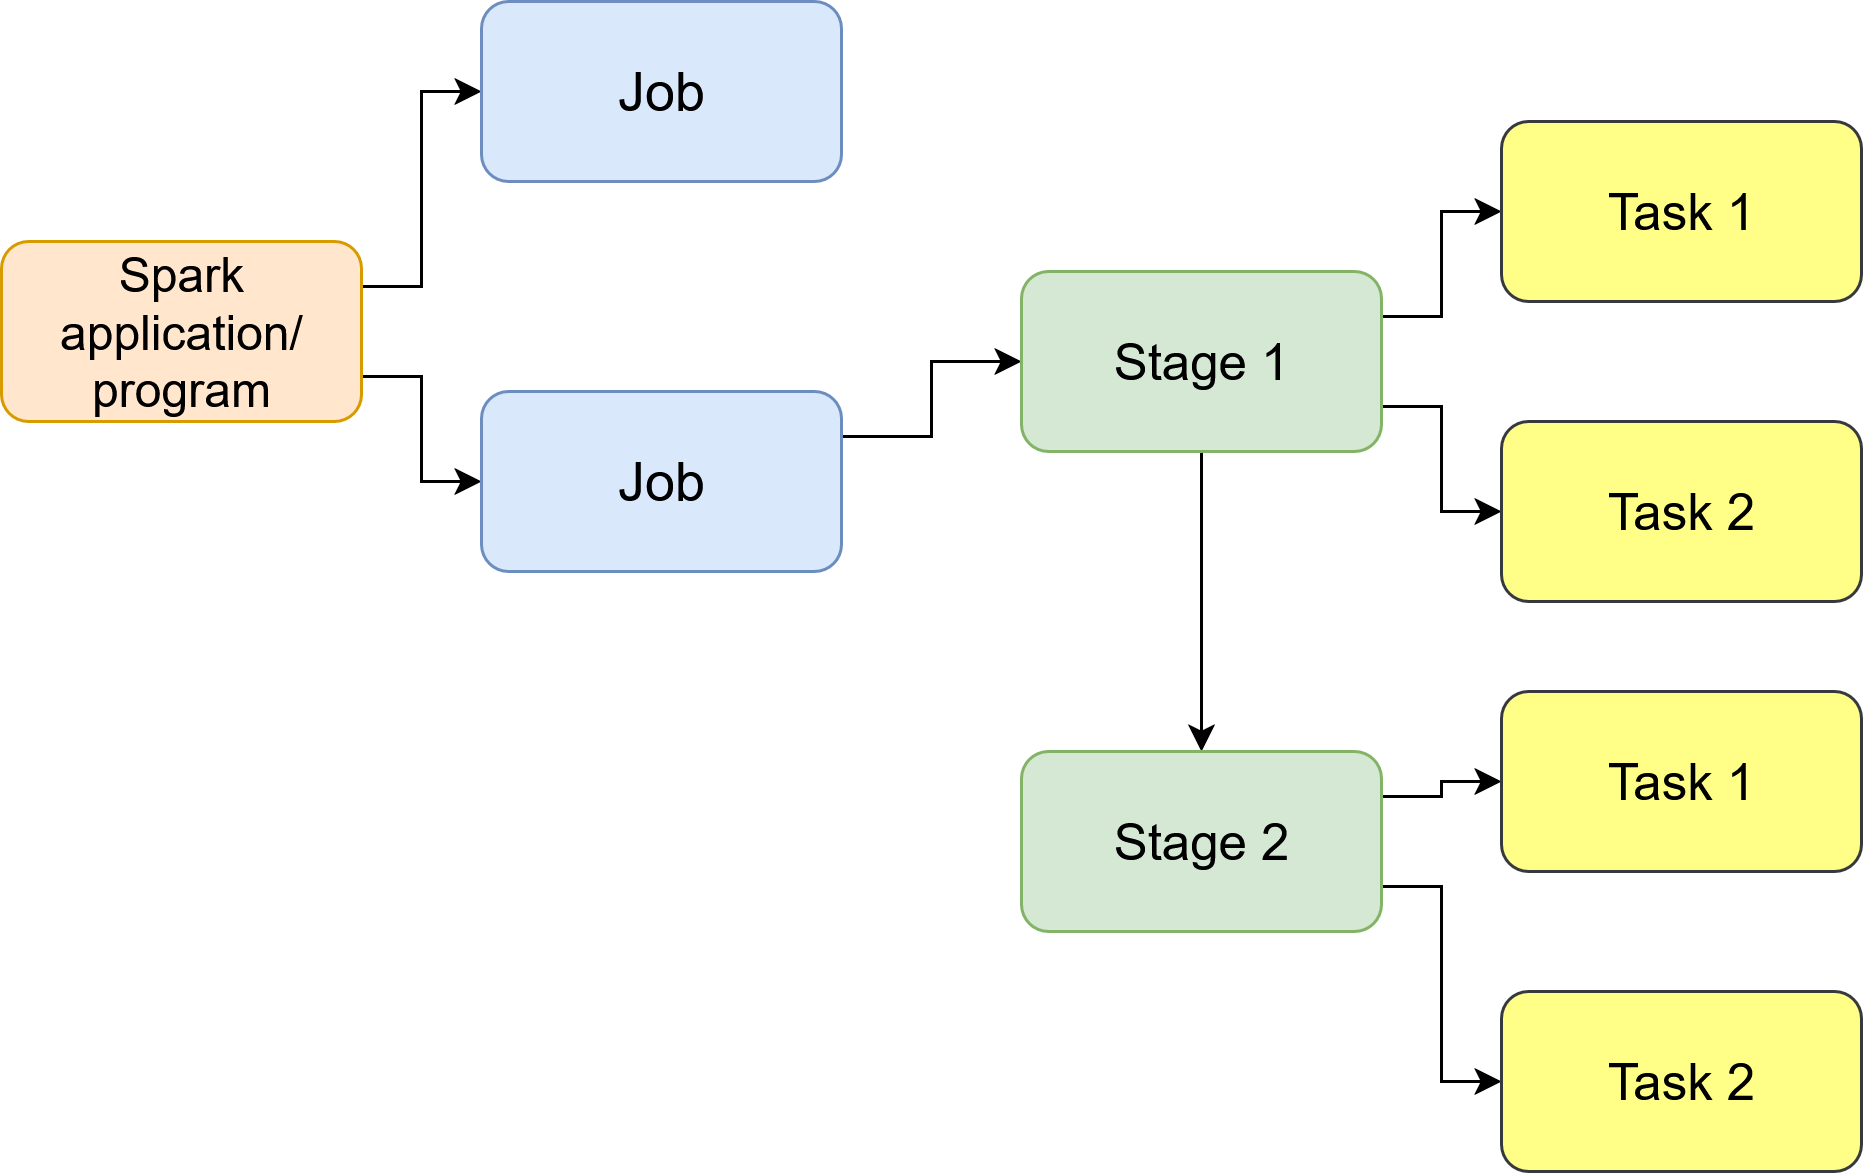

In [1]:
from IPython.display import Image
display(Image("img/spark_app.png", width=600))

So a Spark program, via an *action*, spawns multiple Jobs. Each job has multiple Stages and during each stage there are Tasks which run in *parallel* using a "Shared Nothing" architecture. Each partition is managed by a single task so the number of tasks should correspond to the number of partitions.

````{prf:definition} Shared-Nothing Architecture
:label: def1
:class: dropdown
From Wikipedia:

"A shared-nothing architecture (SN) is a distributed computing architecture in which each update request is satisfied by a single node (processor/memory/storage unit) in a computer cluster. The intent is to eliminate contention among nodes. Nodes do not share (independently access) the same memory or storage.

One alternative architecture is shared everything, in which requests are satisfied by arbitrary combinations of nodes. This may introduce contention, as multiple nodes may seek to update the same data at the same time. It also contrasts with shared-disk and shared-memory architectures."
````

#### Deployment modes

Spark has three deployment modes: cluster, client and local.

1. Local deployment: All computation, so the driver and executor processes, is run locally on the machine submitting the Spark job.

2. Client deployment: The driver process is run on the machine that submitted the Spark job while the executor processes run on worker nodes in a cluster.

3. Cluster mode: Differs from client mode in that the driver process is launched on a node inside the cluster. This means both the execution (executors) and the management of that execution (driver) happen within the cluster, making it better suited for production workloads.

## Spark API

### RDDs

Resilient Distributed Datasets (RDDs) are the basis of most things in Spark such as the higher-level DataFrames API. RDDs are lower level than DataFrames since they expose physical execution characteristics, such as partitions, to the user.

### DataFrame

DataFrames are higher-level abstractions of RDDs that provide SQL-like interface for manipulating the underlying RDDs.

### Catalyst optimizer

This optimizes the execution plan for a query on a dataframe using rule-based and cost-based optimizations

### Photon engine

This is `Databricks`'s query execution engine which optimizes the actual execution of the plan generated by the Catalyst optimizer.

## Structured Streaming

*Spark streaming* was the first streaming capability introduced in Spark in 2013 based on Sparks RDD API. It's records are processed in *microbatches* (DStream - discretized streams) of RDDs.


*Spark **structured** streaming* API was introduced in 2016 and can be thought of an extension of the DataFrame API to streaming data since it allows you to essentially reuse the code written for batch processing jobs, on DataFrames for example, to work with streaming DataFrames which are treated as tables of unbounded size. Spark structured streaming provides exactly-once guarantees meaning each record will be processed exactly once regardless of things such as stream failure. 

````{prf:definition} Streaming
:label: def2
:class: dropdown
Roughly speaking streaming jobs work with data that is unbounded i.e. has no fixed end or beginning, unlike a batch job which works with data of fixed size. Most streaming process process data in time-based microbatches.
````

### Sources and sinks

You can read data into your *source* table from various locations such as from a directory of files or from a streaming data service like Apache Kafka. Similarly, you can write your output data to *sink* locations such as file directories, Apache Kafka or even the console (not recommended for production applications). If using Databricks Autoloader via `cloudFiles` format then autoloader can automatically track new files in storage for ingestion and automatically evolve the schema of the downstream source table based on the schema of the new files.

### Stateful and stateless operations

*Stateless* operations, on streaming DataFrames, process each record/row independently with no memory of previous records. Examples include `filter`, `select` and more.

*Stateful* operations maintain information across micro-batches. Examples include `groupBy`, `join`, `dropDuplicates` and more. This makes sense since grouping necessarily requires information across batches. This is very loosely similar to the distinction between narrow and wide transformations discussed above. To maintain the state checkpointing is used which is part of the exactly-once guarantee of Spark structured streaming.

Spark structured streaming uses `RocksDB` as the backend for storing the state of the stream for stateful operations as it provides efficient storage and retrieval, automatic compaction and supports large state sizes.

### Streaming aggregations

Aggregations when working with streaming datasets are well-defined only when looking at *time windows* of the stream. The three types of windowing strategies are:

1. Tumbling window (fixed size windows that don't overlap) 
2. Sliding window (windows can overlap meaning a record can belong to more than one window)
3. Session window


### Late arriving data

Data can sometimes arrive late due to issues such as network latency or issues arising from having multiple streaming sources. Spark structured streaming uses a *watermark* to determine how long to wait for late arriving data before beginning to process the window for the micro-batch the data is late to arrive for. 

````{prf:example} Watermarking for late arriving data
:label: ex1
Suppose you’re computing a 1-minute windowed count with a watermark of 10 minutes:

Window [12:00–12:01] will stay “open” in memory until 12:11.

If an event with timestamp 12:00:30 arrives at 12:09 → ✅ still accepted.

If it arrives at 12:12 → ❌ too late, dropped.
````

## Spark Optimization

### Common Spark Job Bottlenecks

Shuffles – heavy groupBy/join, high disk + network I/O.

Data Skew – uneven key distribution → straggler tasks.

Serialization – costly object (de)serialization, especially with Java serializer.

Garbage Collection – executors stuck in GC due to poor memory use.

I/O – slow sources/sinks, too many small files.

Driver Bottleneck – large .collect() / .toPandas() overloads driver.

Resource Misconfig – wrong executor/partition sizing → under/overutilization.

Python UDFs – JVM↔Python overhead, GIL limits performance.

### Partitioning

The initial partitions for the data when it is first read by the Spark program, called the initial memory partitions, are determined by the structure of the underlying files that comprise the data being read in e.g. the number of files will influence the number of initial partitions. These number of these partitions is also determined by Spark configuration values like `Spark.sql.files.maxPartitionBytes` or `Spark.default.parallelism`


These partitions are then modified, into shuffle partitions, when wide transformation are performed or the user explicitly repartitions the data with something like `.repartition()`. The number of these partitions is controlled by `Spark.sql.shuffle.partitions`.

One should target partitions of size 100-200 MB and the number of partitions should not be less than the number of available cores. When choosing a partition column it is best to use columns with high cardinality to even out partition distribution. 

#### Skew

Partition skew occurs when your partitions are of uneven size. If some partitions are much larger than others, tasks processing them take longer.
This causes stragglers so some tasks finish quickly, but Spark has to wait for the slow ones, reducing parallelism.

````{prf:example} Partition skew
:label: ex2

Imagine a join on country:

90% of rows belong to "US".

Spark partitions by country.

The "US" partition becomes huge, while other partitions are tiny.

That’s data skew — one task works way harder than the rest.
````



### Task time

One should aim for 50-200ms task time which can be checked via Spark UI.

### Shuffle operations

Shuffles are the most expensive operation in Spark due to the network I/O latency incurred by requiring sending data over the network between workers to redistribute the data. One can minimize the cost of shuffle operations by filtering early and often, using broadcast joins for small tables and configuring shuffle partitions based on data size.

### DataFrame caching

If a dataframe is accessed often it can be useful to cache it via `df.cache()` or `df.persist()` (`df.unpersist()` to uncache) so that the dataframe doesn't get recomputed every time (recall Spark is lazy) one wishes to access it.

### Broadcasting

What it is: A technique to send a small dataset to all executors, so it doesn’t need to be shuffled during joins, lookups or other operations.

Why: Reduces shuffle I/O, speeds up joins with a small table + a large table (a broadcast join).

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import broadcast

spark = SparkSession.builder.getOrCreate()

# Large dataset
sales = spark.read.parquet("s3://bucket/sales")

# Small dataset (e.g., product categories)
products = spark.read.csv("s3://bucket/products.csv", header=True)

# Broadcast join: products is small enough to fit in memory
result = sales.join(broadcast(products), "product_id")

result.show()

### Query optimization

### Catalyst optimizer

Catalyst Optimizer is Spark SQL’s query optimization engine.

It takes your SQL/DataFrame query → builds a logical plan.

Applies rule-based optimizations (predicate pushdown, constant folding, column pruning, etc.).

Optionally uses cost-based optimization (with stats).

Produces an efficient physical plan to execute on the cluster.

```text
SQL / DataFrame API
        │
        ▼
  Unresolved Logical Plan
        │   (syntax only, not yet resolved)
        ▼
  Analyzed Logical Plan
        │   (names, types, relations resolved)
        ▼
  Optimized Logical Plan
        │   (rule-based + cost-based optimizations applied)
        ▼
  Physical Plan
        │   (concrete execution strategy chosen)
        ▼
  Execution

### Adaptive query execution (AQE)

This is an optimization method that optimizes query execution, i.e. the physical plan created by Catalyst, at *runtime* based on actually metrics collected during runtime unlike the catalyst optimizer which optimizes queries at *compile time*.

### Physical join strategies

#### Broadcast Hash Join (BHJ)

One side of the join (the “small” table) is broadcast to all worker nodes.

The large table is streamed and matched against the broadcasted hash map.

Very fast if one dataset is small enough to fit in memory.

#### Shuffle Sort-Merge Join (SMJ) 

Both tables are shuffled on the join key.

Data is then sorted and merged in each partition.

Works well for large-to-large joins, but more expensive due to shuffle + sort.

## Spark connect

### What is Spark Connect?

A new client-server interface for Apache Spark (introduced in Spark 3.4).

Decouples the client (where you write code) from the Spark driver (where execution happens).

Instead of running Spark code inside the driver JVM, you use a thin client that communicates via gRPC.

### How it Works

Client (your notebook, IDE, or app)

Imports the Spark Connect client library.

Builds a logical plan locally (df.filter(...).groupBy(...)).

Sends the logical plan over gRPC to the Spark Connect server.

Spark Connect Server (on cluster)

Runs inside the Spark driver.

Optimizes the logical plan with Catalyst and AQE.

Executes the query on the cluster and streams results back to the client.

### Why it Matters

Decoupling → client is lightweight and doesn’t need Spark runtime.

Multi-language support → Python, Scala, Java, R, SQL, REST/gRPC.

Interactivity → like a database client connection, great for notebooks/IDEs.

Version flexibility → clients don’t need to tightly match Spark cluster internals.

Deploy anywhere → connect from laptops, containers, or cloud services.

##  Client vs Cluster Mode

These apply to Spark’s traditional deployment modes (when you use spark-submit):

### Client mode

The Spark driver runs on the machine where you launch the job (e.g., your laptop or an edge node).

Executors run on the cluster.

Driver↔Executors communicate over the network.

### Cluster mode

Both the Spark driver and executors run inside the cluster.

The cluster manager (YARN, Kubernetes, standalone) launches the driver.

Your machine just submits the job and can disconnect after.

## Practice questions

These are practice exam questions from the March 2025 practice exam provided by Databricks for the 'Databricks Certified Associate Developer for Apache Spark 3.0 - Python' certification exam. The pdf of the exam is available in the `pdfs/` folder of this section in the JupyterBook.

NOTE: These practice questions may not be as relevant for the new version of the exam as of October 2025.

### Question 1